<a href="https://colab.research.google.com/github/Chehan2004/DSGP_GROUP_36/blob/treatments_and_recommendations/Fertilizer%26Pesticide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', 25) #to display all columns

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/correlated_tea_data.csv")
df.head()


,soil_type,soil_pH,rainfall_mm_week,temperature_c,humidity_percent,crop_stage,disease,disease_severity,recommended_fertilizer,recommended_dosage_level
0,sandy,5.394405,103.546844,25.257944,68.080715,young,Heliopeltis,high,NPK,normal
1,loam,5.701189,96.879973,28.295122,90.904140,mature,Tea red scab,low,NPK,normal
2,sandy,5.531359,41.057330,26.860391,78.706872,mature,Green mirid bug,low,NPK,low
3,sandy,6.338784,101.353464,25.813906,84.612644,young,Green mirid bug,low,MICRO,delay
4,loam,5.493927,79.397280,30.210973,66.585311,young,Thrips,high,NPK,split


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   soil_type                 2500 non-null   object 
 1   soil_pH                   2500 non-null   float64
 2   rainfall_mm_week          2500 non-null   float64
 3   temperature_c             2500 non-null   float64
 4   humidity_percent          2500 non-null   float64
 5   crop_stage                2500 non-null   object 
 6   disease                   2500 non-null   object 
 7   disease_severity          2500 non-null   object 
 8   recommended_fertilizer    2500 non-null   object 
 9   recommended_dosage_level  2500 non-null   object 
dtypes: float64(4), object(6)
memory usage: 195.4+ KB


In [4]:
# to remove duplicates
duplicates = df.duplicated().sum()
duplicates

np.int64(0)

No duplicate rows found

Handling missing values

In [5]:
# Replacing common missing strings with real NaNs

df = df.replace(["N/A", "none", "None", "-", ""], np.nan)
df.isna().sum()

,0
soil_type,0
soil_pH,0
rainfall_mm_week,0
temperature_c,0
humidity_percent,0
crop_stage,0
disease,0
disease_severity,0
recommended_fertilizer,0
recommended_dosage_level,0


In [6]:
df.shape

(2500, 10)

In [7]:
label_enc = LabelEncoder()

for col in ["soil_type","crop_stage", "disease",  "disease_severity", "recommended_fertilizer", "recommended_dosage_level"]:
    df[col + "_Encoded"] = label_enc.fit_transform(df[col])

In [8]:
df.head()

,soil_type,soil_pH,rainfall_mm_week,temperature_c,humidity_percent,crop_stage,disease,disease_severity,recommended_fertilizer,recommended_dosage_level,soil_type_Encoded,crop_stage_Encoded,disease_Encoded,disease_severity_Encoded,recommended_fertilizer_Encoded,recommended_dosage_level_Encoded
0,sandy,5.394405,103.546844,25.257944,68.080715,young,Heliopeltis,high,NPK,normal,2,1,3,0,2,2
1,loam,5.701189,96.879973,28.295122,90.904140,mature,Tea red scab,low,NPK,normal,1,0,8,1,2,2
2,sandy,5.531359,41.057330,26.860391,78.706872,mature,Green mirid bug,low,NPK,low,2,0,2,1,2,1
3,sandy,6.338784,101.353464,25.813906,84.612644,young,Green mirid bug,low,MICRO,delay,2,1,2,1,1,0
4,loam,5.493927,79.397280,30.210973,66.585311,young,Thrips,high,NPK,split,1,1,9,0,2,3


In [9]:
X = df[
    [
        "soil_type",
        "soil_pH",
        "rainfall_mm_week",
        "temperature_c",
        "humidity_percent",
        "crop_stage",
        "disease",

        "disease_severity"
    ]
]

y = df[["recommended_fertilizer_Encoded", "recommended_dosage_level_Encoded"]]

Adding noise

In [10]:
# X = X + np.random.normal(0, 0.02, X.shape)
# # Flip 3% of labels
# n = int(0.03 * len(y))
# flip_idx = np.random.choice(len(y), n, replace=False)
# y[flip_idx] = np.random.choice(np.unique(y), n)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
print("TRAIN DATA:")
display(X_train.head())

print("\nTEST DATA:")
display(X_test.head())


TRAIN DATA:


,soil_type,soil_pH,rainfall_mm_week,temperature_c,humidity_percent,crop_stage,disease,disease_severity
2055,loam,6.480218,130.469211,31.780313,87.646720,young,Red Rust,low
1961,sandy,5.845529,36.763088,32.956141,83.573697,young,Tea red scab,low
1864,sandy,4.701956,42.900896,26.690467,71.801276,mature,Heliopeltis,medium
2326,sandy,6.360797,93.872956,29.661579,68.122957,young,Tea red scab,low
461,loam,6.107207,141.440022,31.982095,69.897026,young,brown blight,low



TEST DATA:


,soil_type,soil_pH,rainfall_mm_week,temperature_c,humidity_percent,crop_stage,disease,disease_severity
1447,sandy,5.946896,143.060465,24.183971,79.193612,young,Algal leaf,medium
1114,clay,5.419330,131.406251,25.568821,53.988484,mature,Heliopeltis,medium
1064,clay,5.415992,76.123648,30.230627,61.717881,mature,Algal leaf,low
2287,loam,5.823437,155.945910,30.596754,90.321276,mature,Algal leaf,medium
1537,sandy,6.382242,88.236315,29.450344,93.553697,young,Heliopeltis,low


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Basic summary
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   soil_type                         2500 non-null   object 
 1   soil_pH                           2500 non-null   float64
 2   rainfall_mm_week                  2500 non-null   float64
 3   temperature_c                     2500 non-null   float64
 4   humidity_percent                  2500 non-null   float64
 5   crop_stage                        2500 non-null   object 
 6   disease                           2500 non-null   object 
 7   disease_severity                  2500 non-null   object 
 8   recommended_fertilizer            2500 non-null   object 
 9   recommended_dosage_level          2500 non-null   object 
 10  soil_type_Encoded                 2500 non-null   int64  
 11  crop_stage_Encoded                2500 non-null   int64  
 12  diseas

,soil_pH,rainfall_mm_week,temperature_c,humidity_percent,soil_type_Encoded,crop_stage_Encoded,disease_Encoded,disease_severity_Encoded,recommended_fertilizer_Encoded,recommended_dosage_level_Encoded
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,5.493631,94.424858,27.358857,72.673336,0.988000,0.514000,5.028400,1.204000,1.101200,1.526400
std,0.577695,37.417545,3.119776,12.908743,0.808528,0.499904,3.125556,0.740408,0.832848,0.830409
min,4.500023,30.029515,22.002651,50.002377,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000680,61.959230,24.702927,61.687987,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000
50%,5.494503,93.955434,27.287888,72.613458,1.000000,1.000000,5.000000,1.000000,1.000000,2.000000
75%,5.996726,126.500516,29.946764,83.975050,2.000000,1.000000,8.000000,2.000000,2.000000,2.000000
max,6.499115,159.929889,32.991280,94.985294,2.000000,1.000000,10.000000,2.000000,2.000000,3.000000


<Axes: >

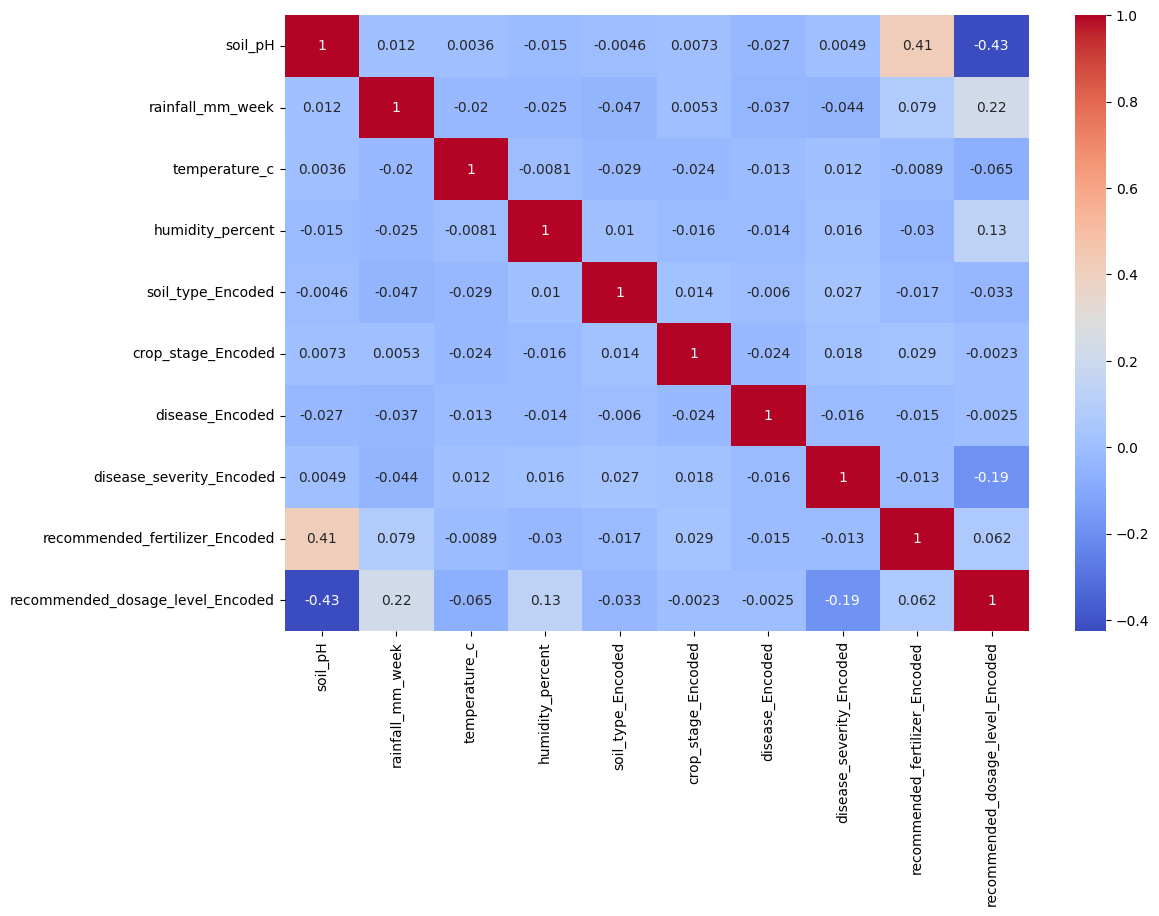

In [14]:

# 2. Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm")

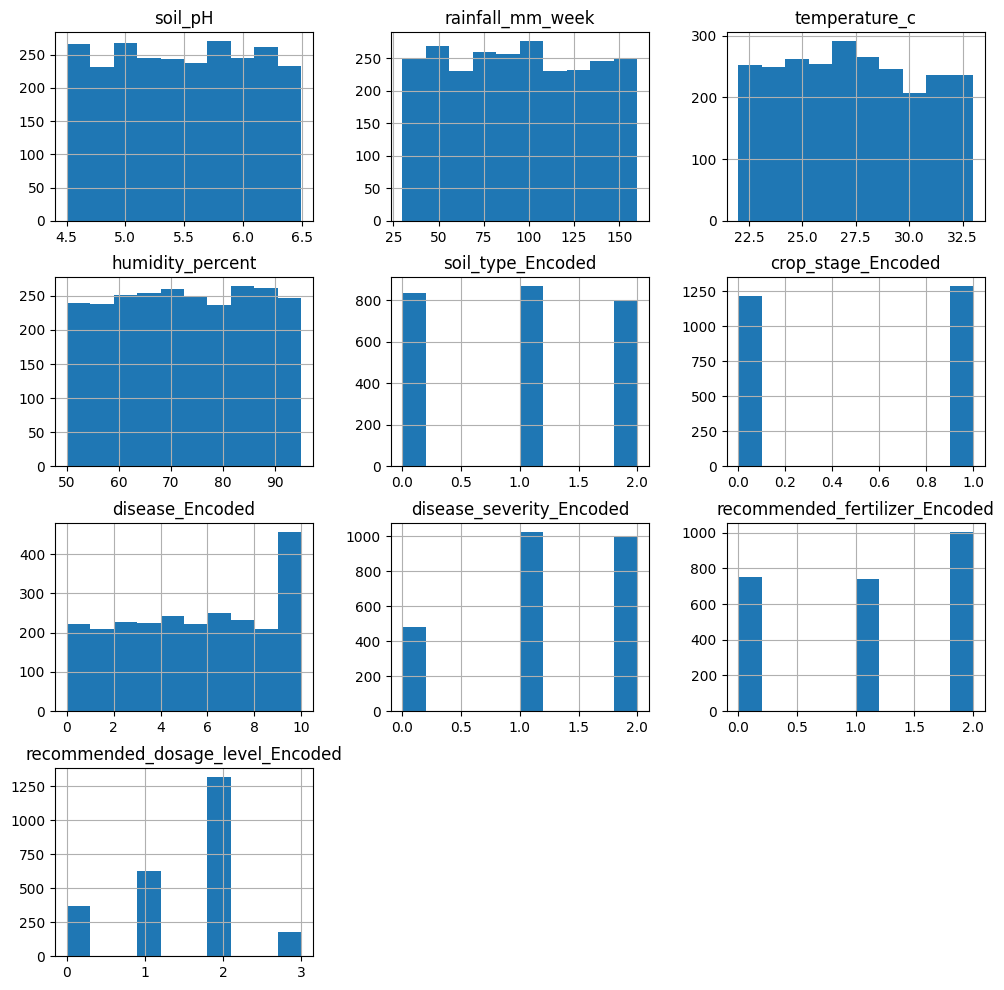

In [15]:
# 3. Distributions
df.hist(figsize=(12,12))
plt.show()


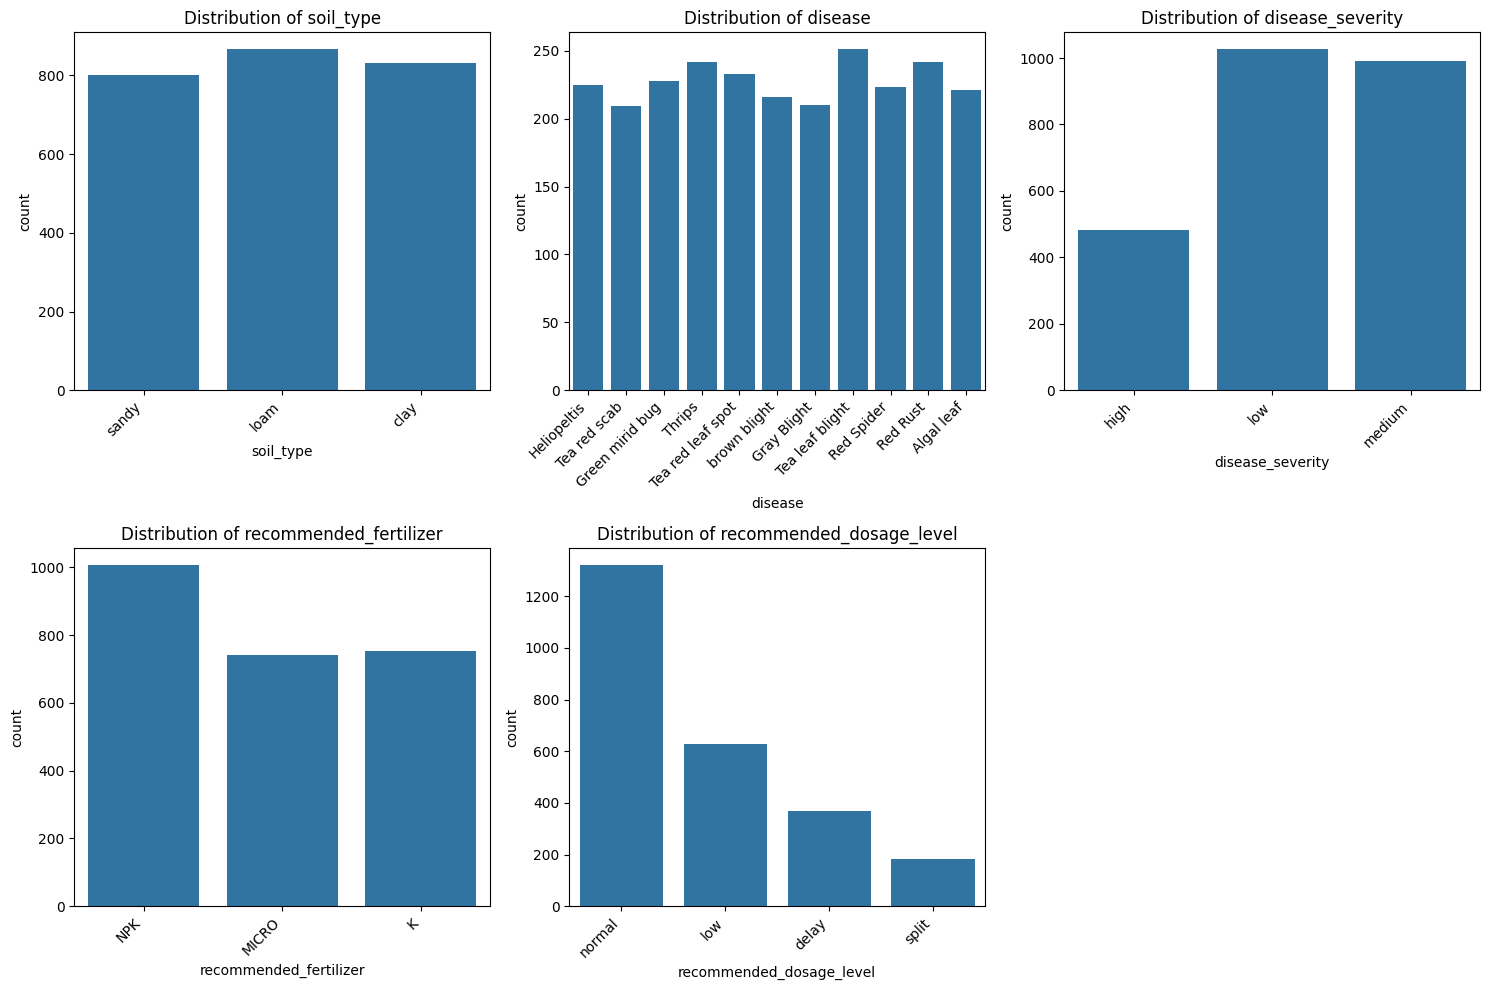

In [16]:
# Countplots for categorical columns
categorical_cols = ["soil_type", "disease", "disease_severity", "recommended_fertilizer", "recommended_dosage_level"]

plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols):
    plt.subplot(2, 3, i + 1) # Adjust subplot grid as needed
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

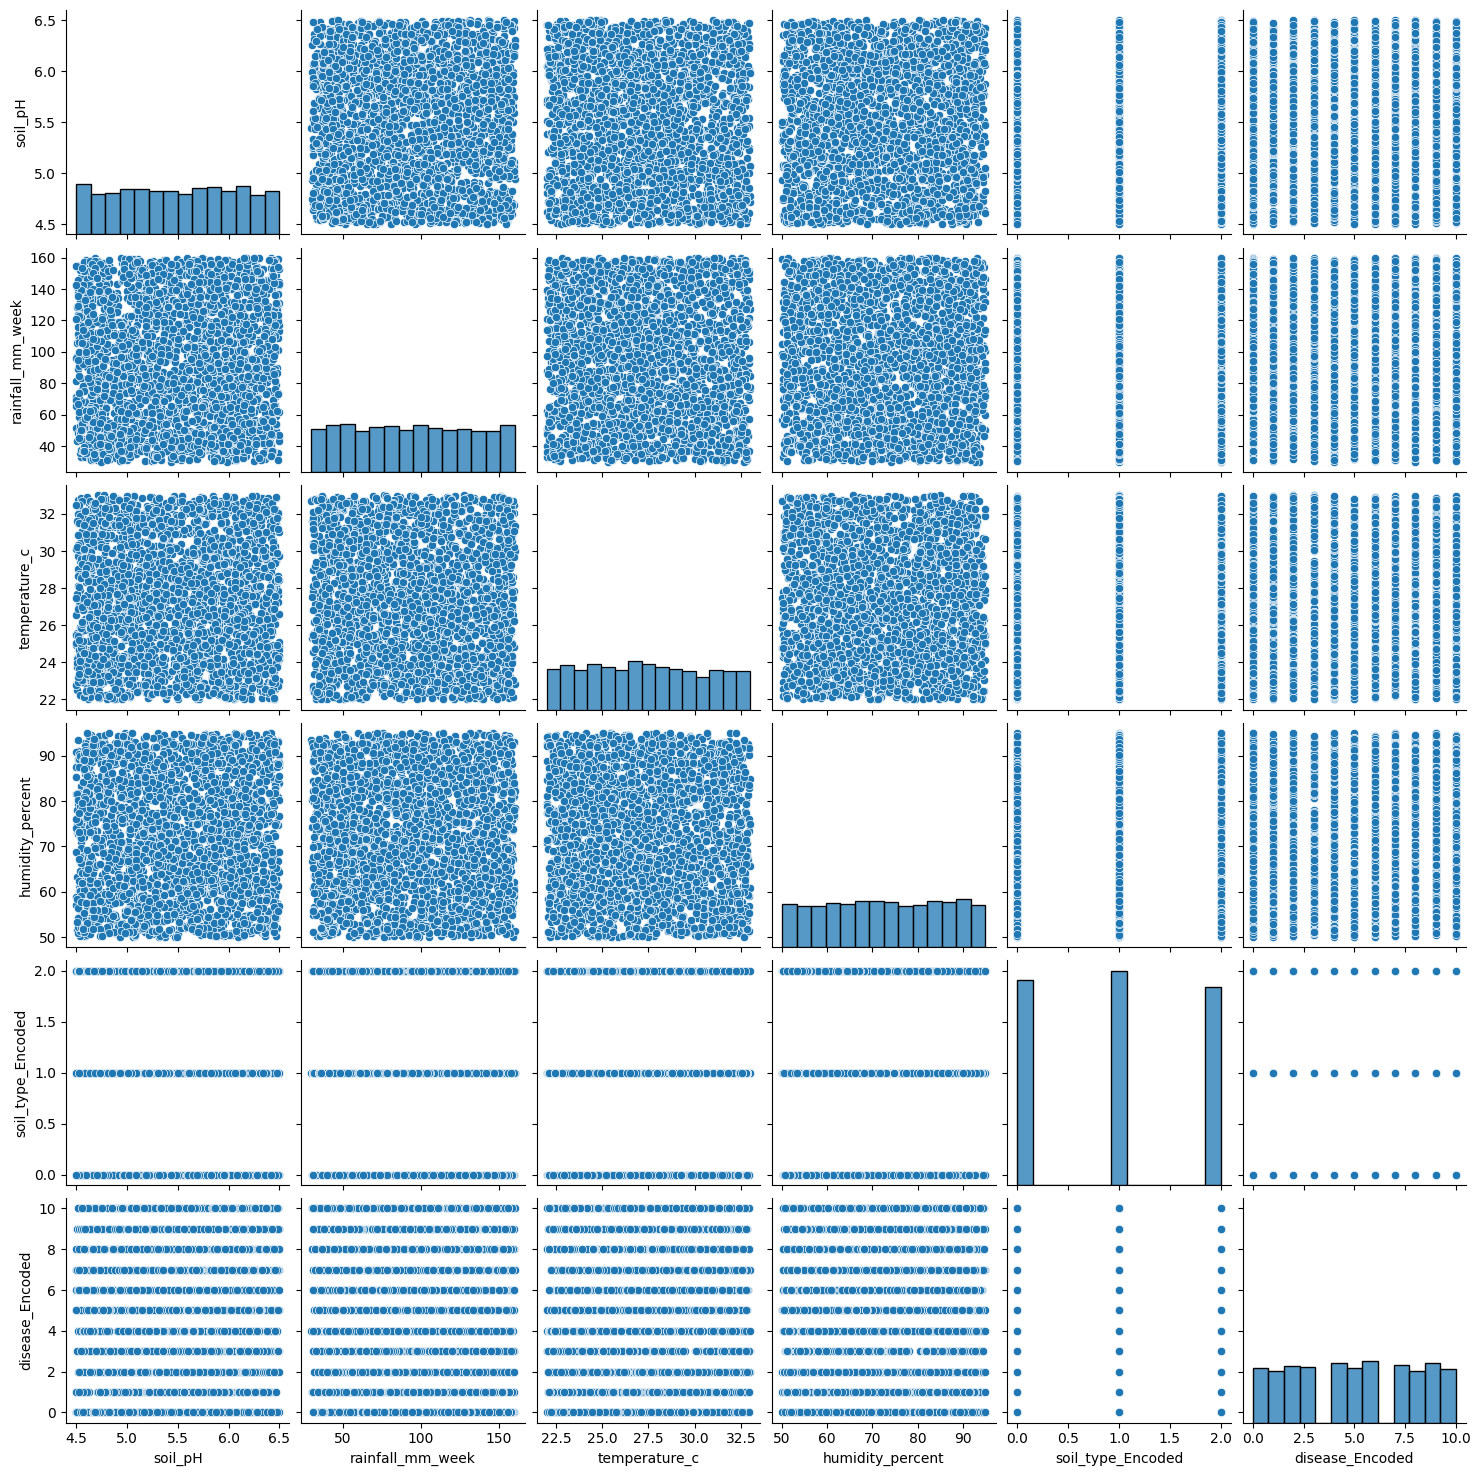

In [17]:

sns.pairplot(df[["soil_pH", "rainfall_mm_week", "temperature_c", "humidity_percent", "soil_type_Encoded", "disease_Encoded"]])
plt.show()

#Random Forest

In [18]:
le_fert = LabelEncoder()
le_dose = LabelEncoder()

y_train_enc = pd.DataFrame({
    "fertilizer": le_fert.fit_transform(y_train["recommended_fertilizer_Encoded"]),
    "dosage": le_dose.fit_transform(y_train["recommended_dosage_level_Encoded"])
})

y_test_enc = pd.DataFrame({
    "fertilizer": le_fert.transform(y_test["recommended_fertilizer_Encoded"]),
    "dosage": le_dose.transform(y_test["recommended_dosage_level_Encoded"])
})

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cat_features = ["soil_type", "disease", "disease_severity"]
num_features = [
    "soil_pH",
    "rainfall_mm_week",
    "temperature_c",
    "humidity_percent"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
        ("num", StandardScaler(), num_features) # Apply StandardScaler to numerical features
    ]
)

In [20]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

rf_model = MultiOutputClassifier(
    RandomForestClassifier(
        n_estimators=200,
        max_depth=12,
        min_samples_leaf=5,
        random_state=42
    )
)


In [21]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("prep", preprocessor),   # OneHotEncoder + numeric passthrough
    ("model", rf_model)
])


Hyperparameter tuning

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

# Define the pipeline with preprocessor and MultiOutputClassifier
rf_pipeline = Pipeline([
    ('prep', preprocessor),  # Use the preprocessor defined earlier
    ('clf', MultiOutputClassifier(RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
        )))
])

# Define parameters for GridSearchCV. These parameters now refer to the RandomForestClassifier within the pipeline.
params = {
    "clf__estimator__n_estimators": [100, 200, 300],
    "clf__estimator__max_depth": [5, 10, 20, None],
    "clf__estimator__min_samples_split": [2, 5, 10]
}
def custom_accuracy(y_true, y_pred):
    # subset accuracy: BOTH outputs must be correct
    return np.mean(np.all(y_true == y_pred, axis=1))

# Initialize GridSearchCV with the pipeline and parameters, using our custom_accuracy scorer
grid = GridSearchCV(rf_pipeline, params, cv=3, n_jobs=-1, scoring=custom_accuracy) # Use the custom_accuracy scorer

# Fit GridSearchCV
grid.fit(X_train, y_train_enc) # Use y_train_enc as it's the processed target

print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'clf__estimator__max_depth': 5, 'clf__estimator__min_samples_split': 2, 'clf__estimator__n_estimators': 100}


In [23]:
# Fit the pipeline before making predictions
rf_pipeline.fit(X_train, y_train_enc)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['soil_type', 'disease',
                                                   'disease_severity']),
                                                 ('num', StandardScaler(),
                                                  ['soil_pH',
                                                   'rainfall_mm_week',
                                                   'temperature_c',
                                                   'humidity_percent'])])),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                                        n_jobs=-1,
                                                                        random_state=42)))])

In [24]:
#rf_pred = pipeline.predict(X_test)
rf_pred = best_model.predict(X_test)

Evaluating random forest

In [25]:
from sklearn.metrics import classification_report

print("FERTILIZER PREDICTION")
print(classification_report(y_test_enc["fertilizer"], rf_pred[:, 0]))

print("\nDOSAGE PREDICTION")
print(classification_report(y_test_enc["dosage"], rf_pred[:, 1]))

FERTILIZER PREDICTION
              precision    recall  f1-score   support

           0       0.86      0.93      0.90       148
           1       0.86      0.89      0.88       142
           2       0.91      0.84      0.87       210

    accuracy                           0.88       500
   macro avg       0.88      0.89      0.88       500
weighted avg       0.88      0.88      0.88       500


DOSAGE PREDICTION
              precision    recall  f1-score   support

           0       0.95      0.89      0.92        82
           1       0.95      0.84      0.89       119
           2       0.93      0.93      0.93       275
           3       0.51      0.92      0.66        24

    accuracy                           0.90       500
   macro avg       0.84      0.90      0.85       500
weighted avg       0.92      0.90      0.91       500



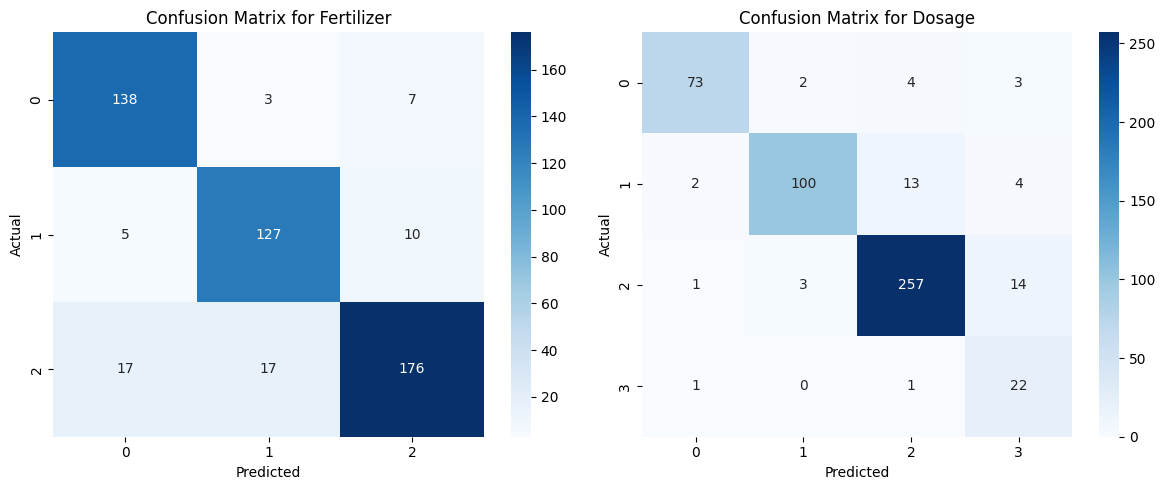

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get target names from y_test_enc (which has 'fertilizer' and 'dosage' columns)
target_names_eval = y_test_enc.columns.tolist()

plt.figure(figsize=(12, 5))

for i, target_name in enumerate(target_names_eval):
    plt.subplot(1, 2, i + 1) # Create subplots for each target
    cm = confusion_matrix(y_test_enc.iloc[:, i], rf_pred[:, i])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {target_name.capitalize()}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()

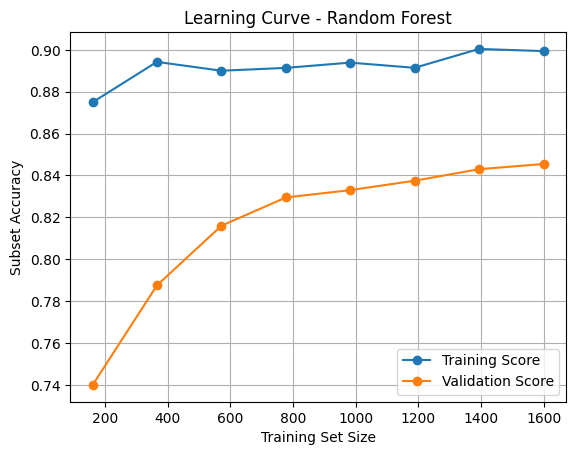

In [27]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer

def subset_accuracy(y_true, rf_pred):
    return np.mean(np.all(y_true ==rf_pred, axis=1))

custom_scorer = make_scorer(subset_accuracy)

train_sizes, train_scores, val_scores = learning_curve(
    pipeline,
    X_train,
    y_train_enc,
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8)
)

train_mean = np.nanmean(train_scores, axis=1)
val_mean = np.nanmean(val_scores, axis=1)

plt.plot(train_sizes, train_mean, 'o-', label="Training Score")
plt.plot(train_sizes, val_mean, 'o-', label="Validation Score")

plt.xlabel("Training Set Size")
plt.ylabel("Subset Accuracy")
plt.title("Learning Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

def get_multioutput_proba(rf_pipeline, X):
    X_trans = rf_pipeline.named_steps["prep"].transform(X)
    estimators = rf_pipeline.named_steps["clf"].estimators_ # Corrected step name from 'rf_model' to 'clf'
    return [est.predict_proba(X_trans) for est in estimators]

def plot_prc_multiclass(y_true_int, proba, class_names, title):
    y_bin = label_binarize(y_true_int, classes=np.arange(len(class_names)))

    plt.figure(figsize=(8, 5))
    for i, cname in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(y_bin[:, i], proba[:, i])
        ap = average_precision_score(y_bin[:, i], proba[:, i])
        plt.plot(recall, precision, label=f"{cname} (AP={ap:.2f})")

    macro_ap = average_precision_score(y_bin, proba, average="macro")
    plt.title(f"{title} | Macro-AP={macro_ap:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.legend()
    plt.show()

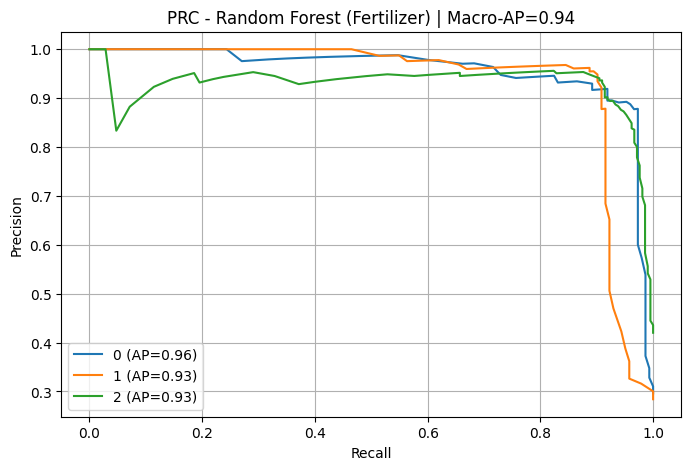

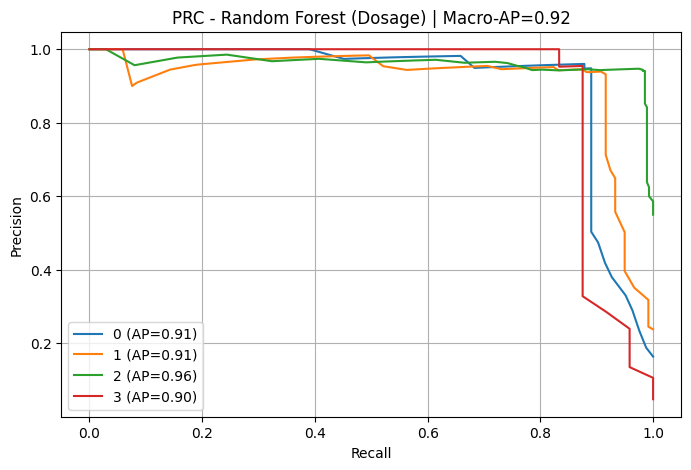

In [29]:
fert_classes = list(le_fert.classes_)
dose_classes = list(le_dose.classes_)

rf_probas = get_multioutput_proba(rf_pipeline, X_test)

# Fertilizer PRC
plot_prc_multiclass(
    y_true_int=y_test_enc["fertilizer"].values,
    proba=rf_probas[0],
    class_names=fert_classes,
    title="PRC - Random Forest (Fertilizer)"
)

# Dosage PRC model
plot_prc_multiclass(
    y_true_int=y_test_enc["dosage"].values,
    proba=rf_probas[1],
    class_names=dose_classes,
    title="PRC - Random Forest (Dosage)"
)


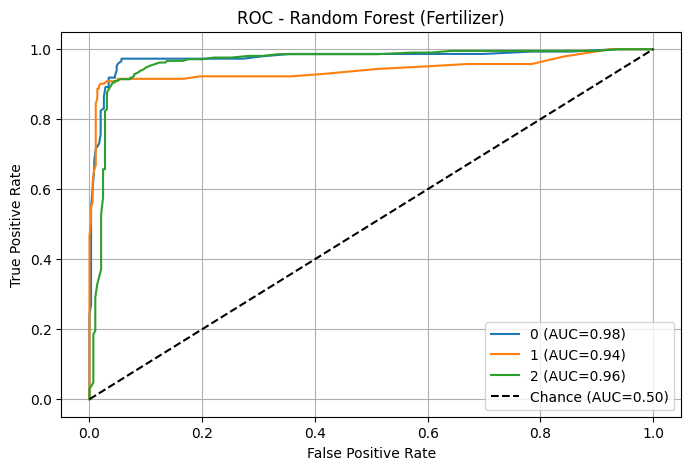

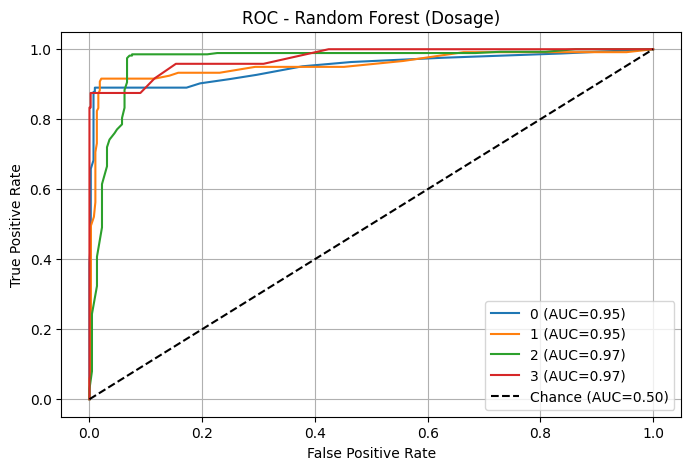

In [30]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_multiclass(y_true_int, proba, class_names, title):
    y_bin = label_binarize(y_true_int, classes=np.arange(len(class_names)))

    plt.figure(figsize=(8, 5))
    for i, cname in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_bin[:, i], proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{cname} (AUC={roc_auc:.2f})")

    # Plot chance level
    plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC=0.50)')

    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)
    plt.legend(loc="lower right")
    plt.show()

# Assuming rf_probas, fert_classes, dose_classes, and y_test_enc are already defined and available from previous cells

# Fertilizer ROC
plot_roc_multiclass(
    y_true_int=y_test_enc["fertilizer"].values,
    proba=rf_probas[0],
    class_names=fert_classes,
    title="ROC - Random Forest (Fertilizer)"
)

# Dosage ROC
plot_roc_multiclass(
    y_true_int=y_test_enc["dosage"].values,
    proba=rf_probas[1],
    class_names=dose_classes,
    title="ROC - Random Forest (Dosage)"
)


#Decision tree

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn import tree

In [32]:
#TRAIN MODEL
dt_model = MultiOutputClassifier(
    DecisionTreeClassifier(
        max_depth=8,
        min_samples_leaf=5,
        random_state=42
    )
)

# Pipeline = preprocess + model
dt_pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", dt_model)
])

dt_pipeline.fit(X_train, y_train)

dt_pred = dt_pipeline.predict(X_test)

##Decision tree visualizations

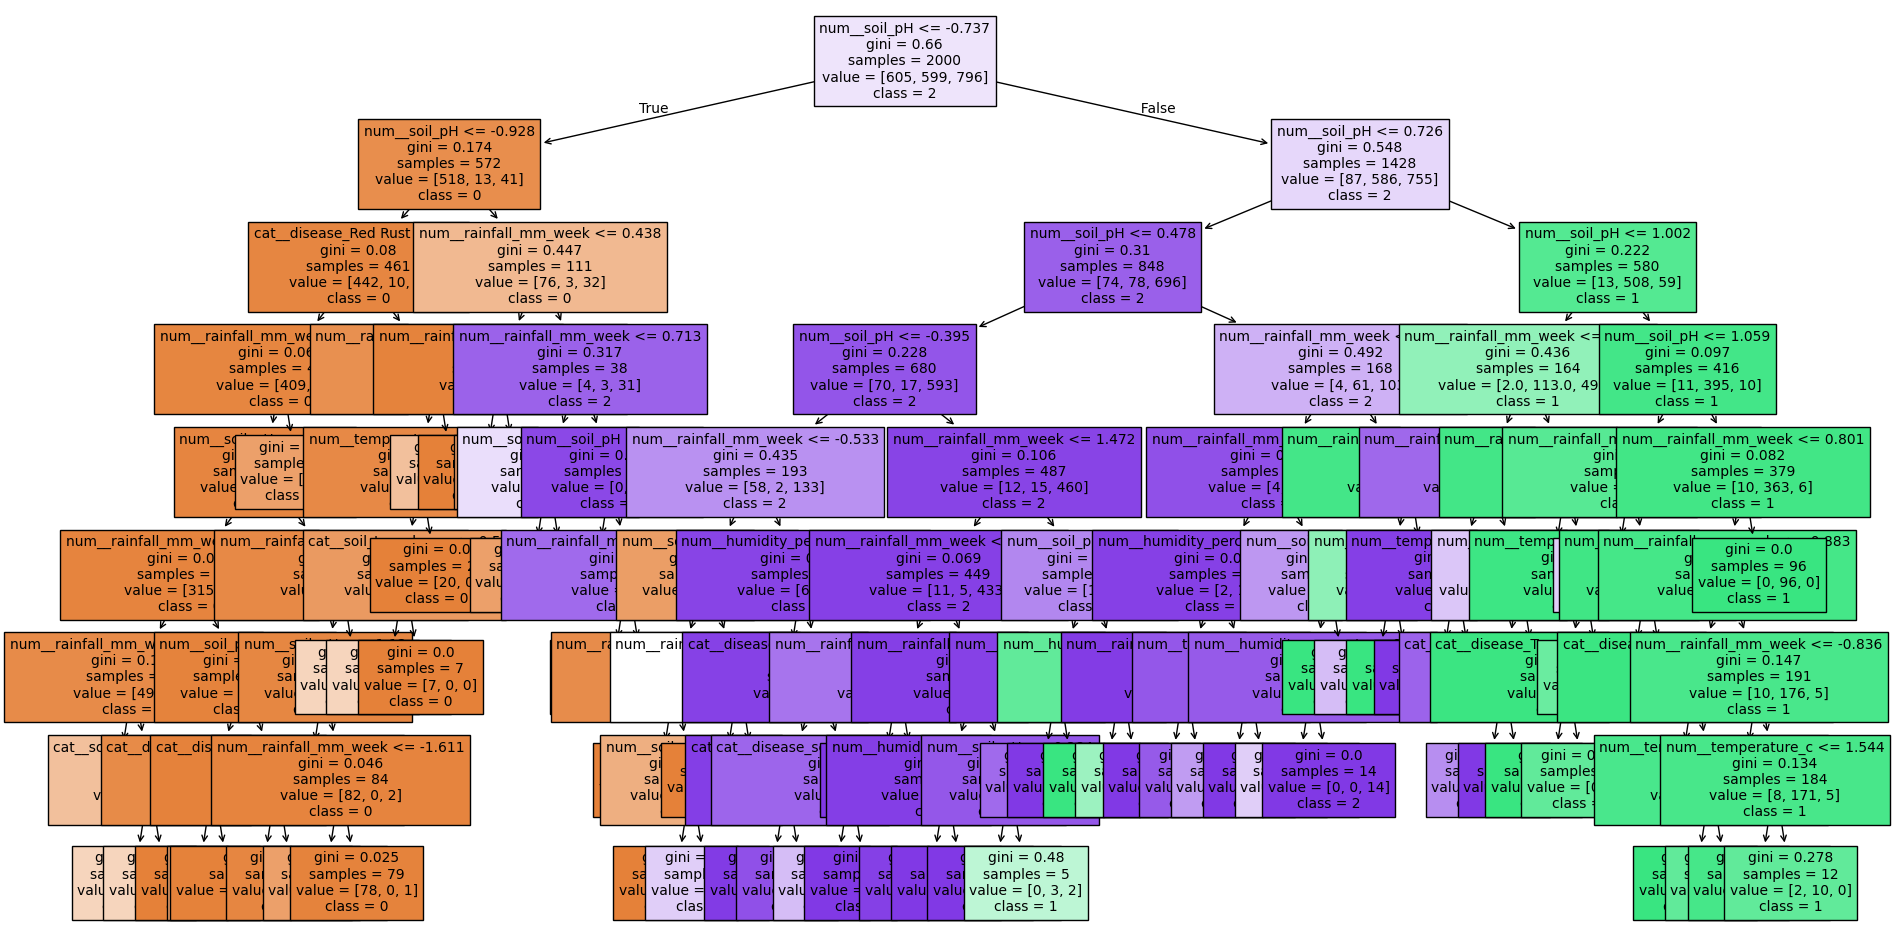

In [33]:
plt.figure(figsize=(22,12))

# Extract the first DecisionTreeClassifier from the MultiOutputClassifier in the pipeline
# pipeline['model'] accesses the MultiOutputClassifier
# .estimators_[0] accesses the first trained DecisionTreeClassifier (for the first output)
individual_dt_estimator = dt_pipeline['model'].estimators_[0]

# Get feature names after preprocessing
feature_names_out = dt_pipeline['prep'].get_feature_names_out()

# Get class names for the first output from the individual estimator
class_names_out = [str(c) for c in individual_dt_estimator.classes_] # Convert class names to string if they are numerical

tree.plot_tree(
    individual_dt_estimator,
    feature_names=feature_names_out,
    class_names=class_names_out,
    filled=True,
    fontsize=10
)
plt.show()

In [34]:
print("FERTILIZER PREDICTION")
print(classification_report(y_test_enc["fertilizer"], dt_pred[:, 0]))

FERTILIZER PREDICTION
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       148
           1       0.95      0.92      0.93       142
           2       0.94      0.93      0.94       210

    accuracy                           0.93       500
   macro avg       0.93      0.93      0.93       500
weighted avg       0.93      0.93      0.93       500



In [35]:
print("\nDOSAGE PREDICTION")
print(classification_report(y_test_enc["dosage"], dt_pred[:, 1]))


DOSAGE PREDICTION
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        82
           1       0.94      0.90      0.92       119
           2       0.95      0.98      0.96       275
           3       0.95      0.88      0.91        24

    accuracy                           0.94       500
   macro avg       0.94      0.91      0.92       500
weighted avg       0.94      0.94      0.94       500



Confusion Matrices for Decision Tree Model:


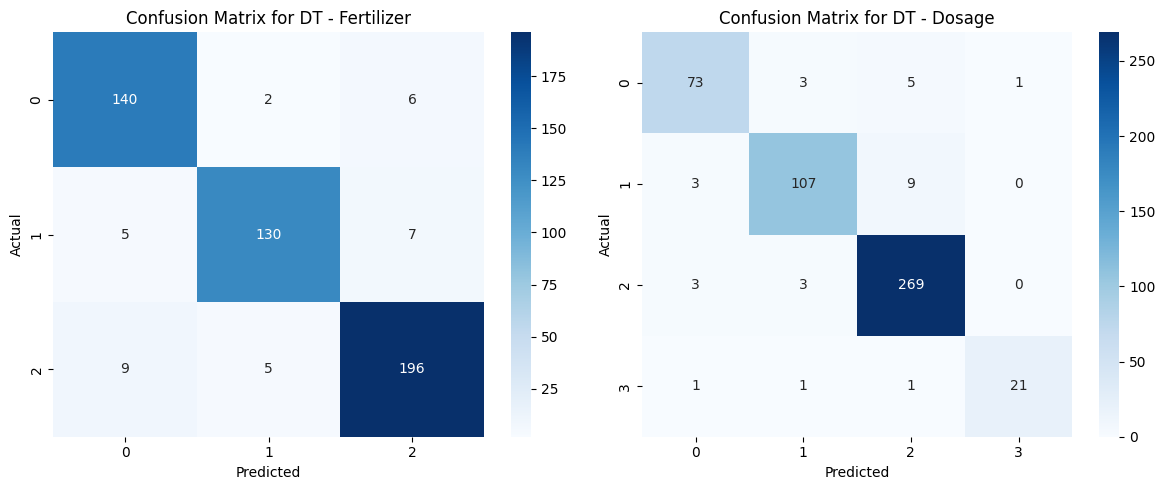

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get target names from y_test_enc (which has 'fertilizer' and 'dosage' columns)
target_names_eval = y_test_enc.columns.tolist()

plt.figure(figsize=(12, 5))

print("Confusion Matrices for Decision Tree Model:")
for i, target_name in enumerate(target_names_eval):
    plt.subplot(1, 2, i + 1) # Create subplots for each target
    # Using dt_pred for Decision Tree predictions
    cm = confusion_matrix(y_test_enc.iloc[:, i], dt_pred[:, i])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for DT - {target_name.capitalize()}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()

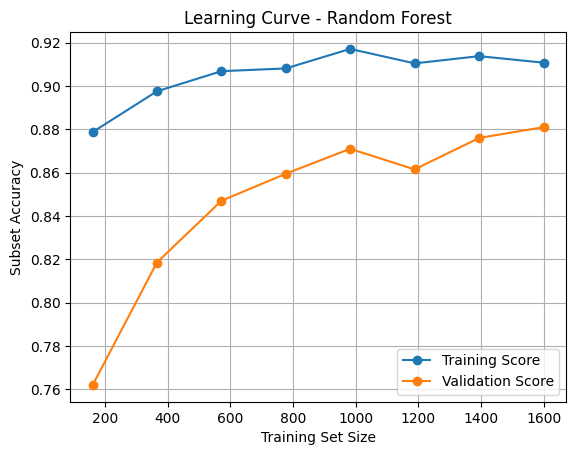

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer

def subset_accuracy(y_true, dt_pred):
    return np.mean(np.all(y_true == dt_pred, axis=1))

custom_scorer = make_scorer(subset_accuracy)

train_sizes, train_scores, val_scores = learning_curve(
    dt_pipeline,
    X_train,
    y_train_enc.values,                 # IMPORTANT: use .values (2D numeric)
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8),
    error_score="raise"                 # IMPORTANT: shows the real error instead of NaNs
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.plot(train_sizes, train_mean, 'o-', label="Training Score")
plt.plot(train_sizes, val_mean, 'o-', label="Validation Score")

plt.xlabel("Training Set Size")
plt.ylabel("Subset Accuracy")
plt.title("Learning Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

In [38]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

def get_multioutput_proba(dt_pipeline, X):
    X_trans = dt_pipeline.named_steps["prep"].transform(X)
    estimators = dt_pipeline.named_steps["model"].estimators_ # Corrected step name from 'clf' to 'model'
    return [est.predict_proba(X_trans) for est in estimators]

def plot_prc_multiclass(y_true_int, proba, class_names, title):
    y_bin = label_binarize(y_true_int, classes=np.arange(len(class_names)))

    plt.figure(figsize=(8, 5))
    for i, cname in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(y_bin[:, i], proba[:, i])
        ap = average_precision_score(y_bin[:, i], proba[:, i])
        plt.plot(recall, precision, label=f"{cname} (AP={ap:.2f})")

    macro_ap = average_precision_score(y_bin, proba, average="macro")
    plt.title(f"{title} | Macro-AP={macro_ap:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.legend()
    plt.show()

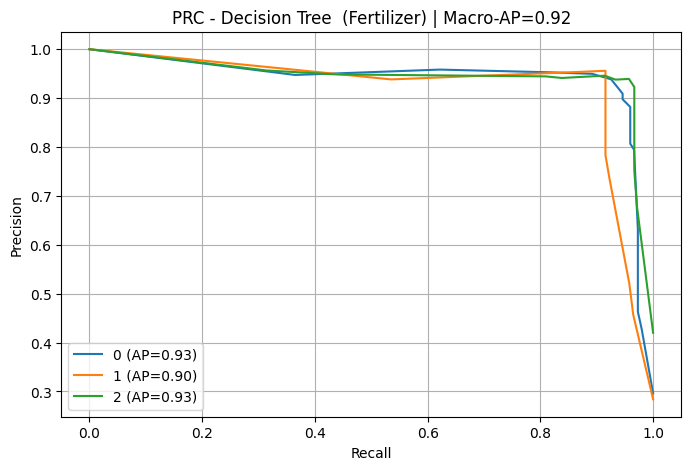

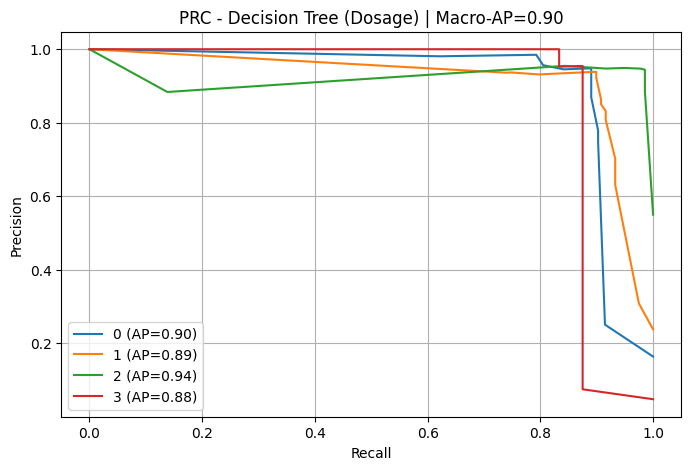

In [39]:
fert_classes = list(le_fert.classes_)
dose_classes = list(le_dose.classes_)

dt_probas = get_multioutput_proba(dt_pipeline, X_test)

# Fertilizer PRC
plot_prc_multiclass(
    y_true_int=y_test_enc["fertilizer"].values,
    proba=dt_probas[0],
    class_names=fert_classes,
    title="PRC - Decision Tree  (Fertilizer)"
)

# Dosage PRC model
plot_prc_multiclass(
    y_true_int=y_test_enc["dosage"].values,
    proba=dt_probas[1],
    class_names=dose_classes,
    title="PRC - Decision Tree (Dosage)"
)


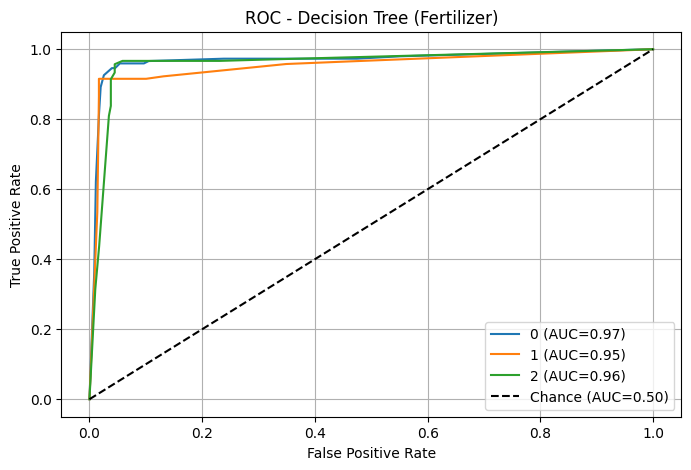

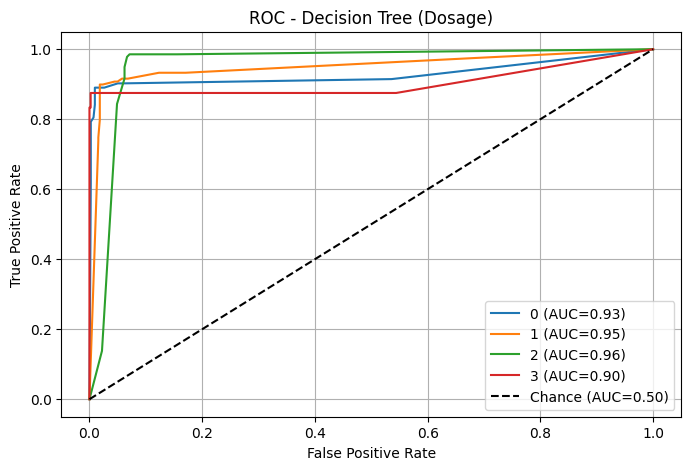

In [40]:
# def plot_roc_multiclass(y_true_int, proba, class_names, title):
#     y_bin = label_binarize(y_true_int, classes=np.arange(len(class_names)))

#     plt.figure(figsize=(8, 5))
#     for i, cname in enumerate(class_names):
#         fpr, tpr, _ = roc_curve(y_bin[:, i], proba[:, i])
#         roc_auc = auc(fpr, tpr)
#         plt.plot(fpr, tpr, label=f"{cname} (AUC={roc_auc:.2f})")

#     # Plot chance level
#     plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC=0.50)')

#     plt.title(title)
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.grid(True)
#     plt.legend(loc="lower right")
#     plt.show()

# Fertilizer ROC
plot_roc_multiclass(
    y_true_int=y_test_enc["fertilizer"].values,
    proba=dt_probas[0],
    class_names=fert_classes,
    title="ROC - Decision Tree (Fertilizer)"
)

# Dosage ROC
plot_roc_multiclass(
    y_true_int=y_test_enc["dosage"].values,
    proba=dt_probas[1],
    class_names=dose_classes,
    title="ROC - Decision Tree (Dosage)"
)


#Gradient boosting

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = MultiOutputClassifier(
    GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.01,
        max_depth=3,
        random_state=42
    )
)

In [42]:
gb_pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", gb_model)
])

In [43]:
gb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['soil_type', 'disease',
                                                   'disease_severity']),
                                                 ('num', StandardScaler(),
                                                  ['soil_pH',
                                                   'rainfall_mm_week',
                                                   'temperature_c',
                                                   'humidity_percent'])])),
                ('model',
                 MultiOutputClassifier(estimator=GradientBoostingClassifier(learning_rate=0.01,
                                                                            random_state=42)))])

In [44]:
gb_pred = gb_pipeline.predict(X_test)

In [45]:
print("FERTILIZER PREDICTION")
print(classification_report(y_test_enc["fertilizer"], gb_pred[:, 0]))

FERTILIZER PREDICTION
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       148
           1       0.92      0.89      0.91       142
           2       0.92      0.92      0.92       210

    accuracy                           0.92       500
   macro avg       0.92      0.92      0.92       500
weighted avg       0.92      0.92      0.92       500



In [46]:
print("\nDOSAGE PREDICTION")
print(classification_report(y_test_enc["dosage"], gb_pred[:, 1]))


DOSAGE PREDICTION
              precision    recall  f1-score   support

           0       0.96      0.83      0.89        82
           1       0.92      0.85      0.88       119
           2       0.91      0.98      0.95       275
           3       0.91      0.88      0.89        24

    accuracy                           0.92       500
   macro avg       0.93      0.88      0.90       500
weighted avg       0.92      0.92      0.92       500



In [47]:
def subset_accuracy(y_true, gb_pred):
    return np.mean(np.all(y_true == gb_pred, axis=1))

custom_scorer = make_scorer(subset_accuracy)

In [48]:

train_sizes, train_scores, val_scores = learning_curve(
    gb_pipeline,
    X_train,
    y_train_enc.values,                 # IMPORTANT (2D numeric)
    cv=3,                               # start with 3, can increase later
    scoring=custom_scorer,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8),
    error_score="raise"                 # avoids silent NaNs
)

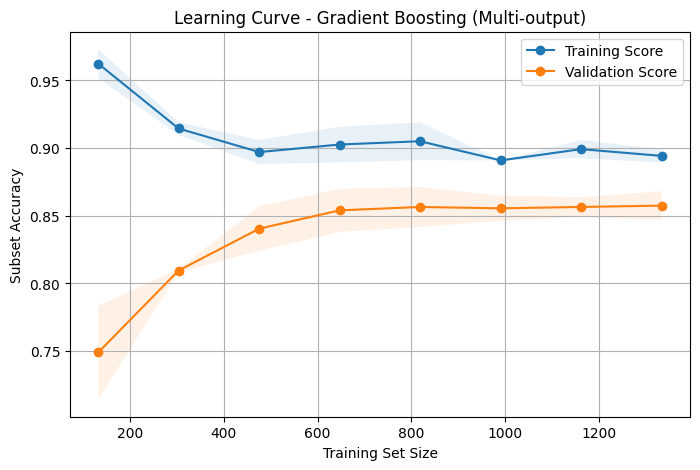

In [49]:
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, "o-", label="Training Score")
plt.plot(train_sizes, val_mean, "o-", label="Validation Score")

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1)
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1)

plt.title("Learning Curve - Gradient Boosting (Multi-output)")
plt.xlabel("Training Set Size")
plt.ylabel("Subset Accuracy")
plt.grid(True)
plt.legend()
plt.show()

In [50]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

def get_multioutput_proba(gb_pipeline, X):
    X_trans = gb_pipeline.named_steps["prep"].transform(X)
    estimators = gb_pipeline.named_steps["model"].estimators_ # Corrected step name from 'clf' to 'model'
    return [est.predict_proba(X_trans) for est in estimators]

def plot_prc_multiclass(y_true_int, proba, class_names, title):
    y_bin = label_binarize(y_true_int, classes=np.arange(len(class_names)))

    plt.figure(figsize=(8, 5))
    for i, cname in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(y_bin[:, i], proba[:, i])
        ap = average_precision_score(y_bin[:, i], proba[:, i])
        plt.plot(recall, precision, label=f"{cname} (AP={ap:.2f})")

    macro_ap = average_precision_score(y_bin, proba, average="macro")
    plt.title(f"{title} | Macro-AP={macro_ap:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.legend()
    plt.show()

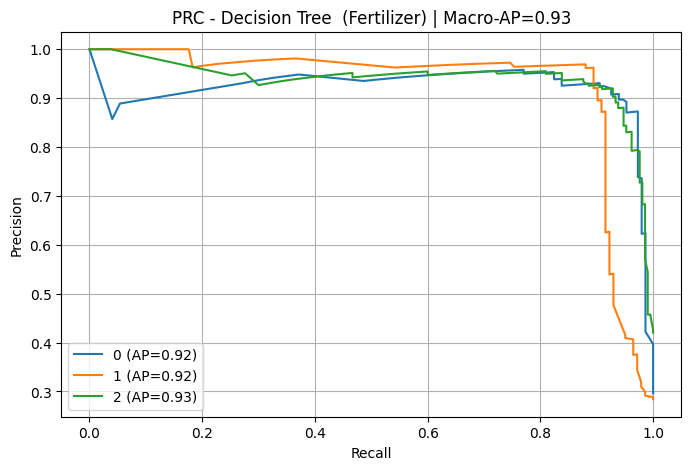

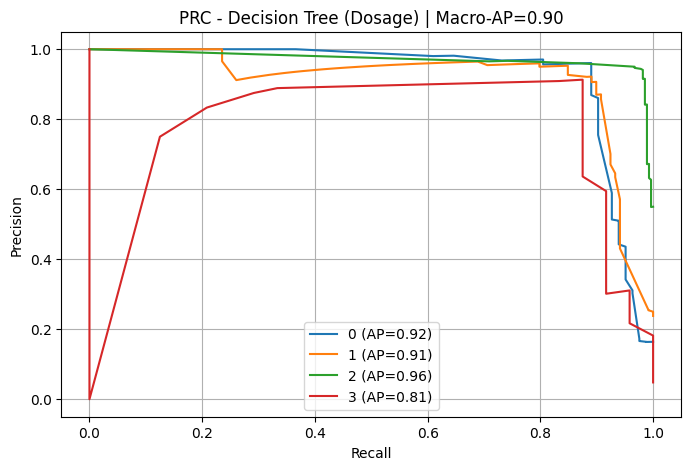

In [51]:
fert_classes = list(le_fert.classes_)
dose_classes = list(le_dose.classes_)

gb_probas = get_multioutput_proba(gb_pipeline, X_test)

# Fertilizer PRC
plot_prc_multiclass(
    y_true_int=y_test_enc["fertilizer"].values,
    proba=gb_probas[0],
    class_names=fert_classes,
    title="PRC - Decision Tree  (Fertilizer)"
)

# Dosage PRC model
plot_prc_multiclass(
    y_true_int=y_test_enc["dosage"].values,
    proba=gb_probas[1],
    class_names=dose_classes,
    title="PRC - Decision Tree (Dosage)"
)


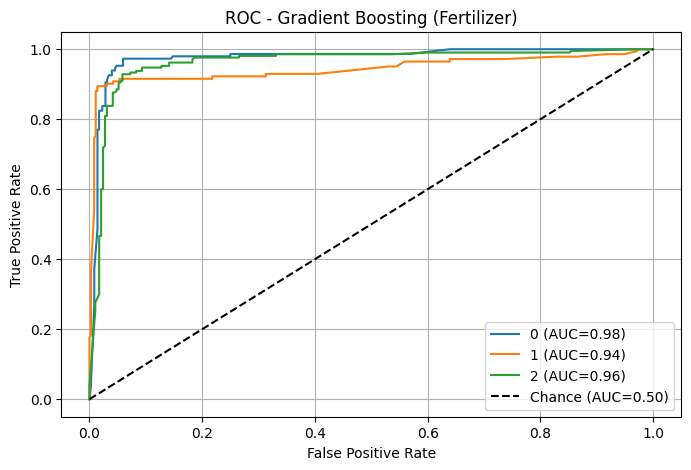

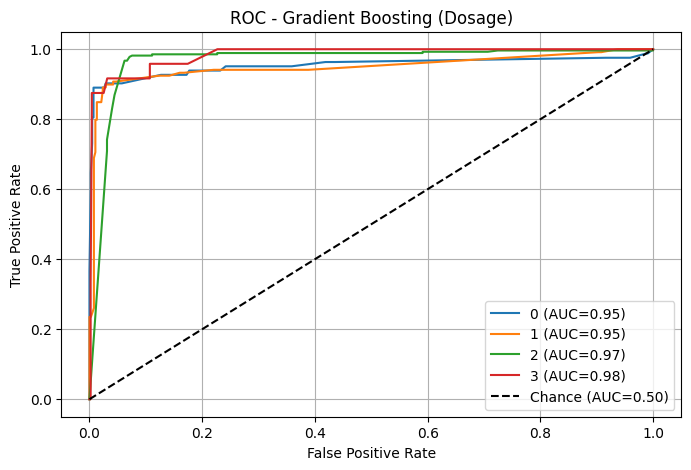

In [52]:
# Fertilizer ROC for Gradient Boosting
plot_roc_multiclass(
    y_true_int=y_test_enc["fertilizer"].values,
    proba=gb_probas[0],
    class_names=fert_classes,
    title="ROC - Gradient Boosting (Fertilizer)"
)

# Dosage ROC for Gradient Boosting
plot_roc_multiclass(
    y_true_int=y_test_enc["dosage"].values,
    proba=gb_probas[1],
    class_names=dose_classes,
    title="ROC - Gradient Boosting (Dosage)"
)

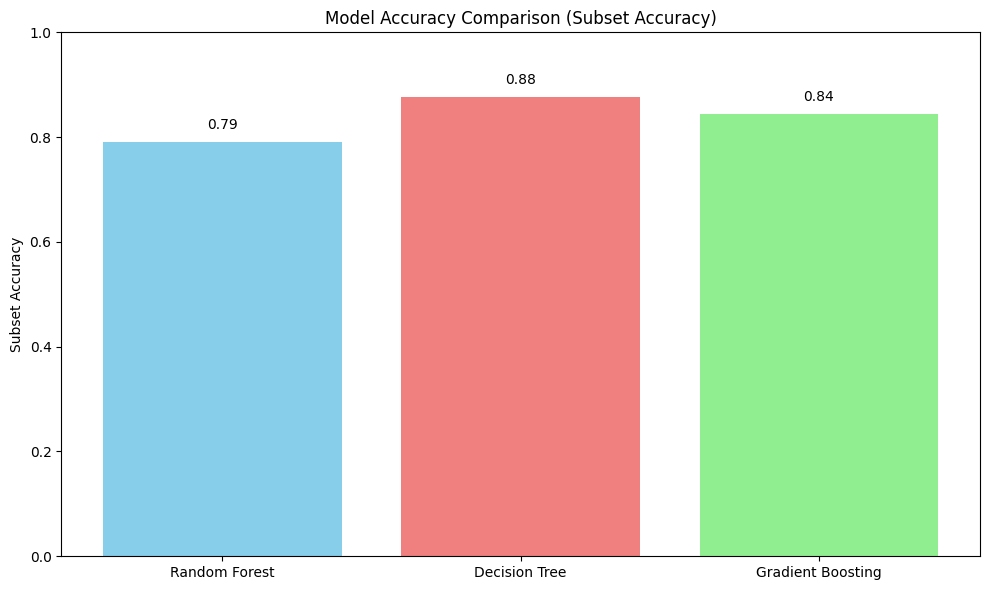

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate subset accuracy for each model
rf_accuracy = np.mean(np.all(y_test_enc.values == rf_pred, axis=1))
dt_accuracy = np.mean(np.all(y_test_enc.values == dt_pred, axis=1))
gb_accuracy = np.mean(np.all(y_test_enc.values == gb_pred, axis=1))

# Model names and their accuracies
models = ['Random Forest', 'Decision Tree', 'Gradient Boosting']
accuracies = [rf_accuracy, dt_accuracy, gb_accuracy]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.ylim(0, 1) # Accuracy ranges from 0 to 1
plt.ylabel('Subset Accuracy')
plt.title('Model Accuracy Comparison (Subset Accuracy)')

# Add accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [54]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import numpy as np

def subset_accuracy(y_true, y_pred):
    # This assumes y_true and y_pred are 2D arrays
    return np.mean(np.all(y_true == y_pred, axis=1))

scorer = make_scorer(subset_accuracy)

dt_scores = cross_val_score(
    dt_pipeline,
    X_train,  # Changed from X to X_train to match y_train_enc.values
    y_train_enc.values,  # Pass y_train as a 2D numpy array
    cv=5,
    scoring= scorer, # Use the custom scorer
    n_jobs=-1 # Use all available cores
)

print("Cross-Validation Scores:", dt_scores)
print("Mean CV Score:", np.mean(dt_scores))
print("Standard Deviation of CV Scores:", np.std(dt_scores))

Cross-Validation Scores: [0.875  0.8925 0.8775 0.8925 0.8675]
Mean CV Score: 0.881
Standard Deviation of CV Scores: 0.009949874371066172


In [55]:

# rf_scores = cross_val_score(
#     rf_pipeline,
#     X_train,  # Changed from X to X_train to match y_train_enc.values
#     y_train_enc.values,  # Pass y_train as a 2D numpy array
#     cv=5,
#     scoring= scorer, # Use the custom scorer
#     n_jobs=-1 # Use all available cores
# )

# print("Cross-Validation Scores:", rf_scores)
# print("Mean CV Score:", np.mean(rf_scores))
# print("Standard Deviation of CV Scores:", np.std(rf_scores))

In [57]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Make sure targets are strings
fert_text = df['recommended_fertilizer'].astype(str)
dose_text = df['recommended_dosage_level'].astype(str)

le_fert = LabelEncoder()
le_dose = LabelEncoder()

y_fert = le_fert.fit_transform(fert_text)
y_dose = le_dose.fit_transform(dose_text)

y = np.column_stack((y_fert, y_dose))

In [58]:
import joblib

joblib.dump(dt_pipeline, "tea_dt_pipeline.pkl")
joblib.dump(le_fert, "le_fert.pkl")
joblib.dump(le_dose, "le_dose.pkl")

print("Saved model + encoders ✅")


Saved model + encoders ✅


In [59]:
pipeline_loaded = joblib.load("tea_dt_pipeline.pkl")
le_fert_loaded = joblib.load("le_fert.pkl")
le_dose_loaded = joblib.load("le_dose.pkl")

sample = X_test.iloc[[0]]

pred = pipeline_loaded.predict(sample)[0]

fert = le_fert_loaded.inverse_transform([pred[0]])[0]
dose = le_dose_loaded.inverse_transform([pred[1]])[0]

print("Predicted fertilizer:", fert)
print("Predicted dosage:", dose)

Predicted fertilizer: MICRO
Predicted dosage: normal


In [61]:
from google.colab import files

# Assuming the model and encoders were successfully saved in a previous step.

files.download("tea_dt_pipeline.pkl")
files.download("le_fert.pkl")
files.download("le_dose.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>